### Classificação de Imagens de Modelos de Automóveis utilizando Redes Neurais Convolucionais
**Aluno**: Paulo Roberto Alves de Carvalho Junior
***
Trabalho de Conclusao de Curso apresentado ao Curso de Especializacao em Ciência de Dados e Big Data como requisito parcial à obtenção do tıtulo de especialista.


### Importação das bibliotecas do Pytorch necessárias para execução do projeto

In [1]:
import numpy as np
import torch, torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

### Importação das demais bibliotecas para auxílio ao projeto

Acesso ao sistema de arquivos, gráficos, cálculo de intervalos de tempo etc.


In [2]:
import PIL.Image
import time
from matplotlib import pyplot as plt
import os
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})

### Aplicação das tranformações nas imagens (augmentation)

As imagens foram redimensionadas para 256x256 (`tamanho = 256`, `transforms.Resize(size=[tamanho, tamanho])`) e, para o dataset de treino, foram aplicados espelhamentos horizontais aleatórias `RandomHorizontalFlip()`, conforme proposto [neste artigo](https://learnopencv.com/image-classification-using-transfer-learning-in-pytorch/)


Após transformar as imagens em tensores, seus pixels foram normalizados tendo como entrada a média e desvio padrão para cada canal (Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])) de todas as imagens do ImageNet (dataset utilizado para o treino da AlexNet).

Veja que o dataset está dividido em treino, validação e teste, sendo que o espelhamento só é aplicado à massa de treino:

In [3]:
tamanho = 256
transformacoes_de_imagens = { 
    'treino': transforms.Compose([        
        transforms.Resize(size=[tamanho, tamanho]),
        transforms.RandomHorizontalFlip(),      
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
   ]),
    'validacao': transforms.Compose([
        transforms.Resize(size=[tamanho, tamanho]), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
   'teste': transforms.Compose([
        transforms.Resize(size=[tamanho, tamanho]),
        transforms.ToTensor(),
       transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}


### Definir a localização dos conjuntos de dados e tamano do lote (_batch size_)

O código abaixo define as pastas de treino, teste e validação, além de definir o tamanho do lote em 128 (`bs = 128`).

In [4]:
dataset = r'./dados/'
pasta_treino = os.path.join(dataset, 'treino')
pasta_validacao = os.path.join(dataset, 'validacao')
pasta_teste = os.path.join(dataset, 'teste')

In [5]:
# Tamanho do batch de treinamento
bs = 128

# Determinando o número de classes
numero_de_classes = len(os.listdir(pasta_validacao))
numero_de_classes

5

### Carregar as imagens no formato de _datasets.ImageFolder_ do TorchVision

O código abaixo atribui o conjunto de dados à estrutura utilizada pelos DataLoaders do TorchVision, definindo o local das imagens, bem como suas transformações.

In [6]:
data = {
    'treino': datasets.ImageFolder(root=pasta_treino, transform=transformacoes_de_imagens['treino']),
    'validacao': datasets.ImageFolder(root=pasta_validacao, transform=transformacoes_de_imagens['validacao'])
}

In [7]:
data

{'treino': Dataset ImageFolder
     Number of datapoints: 391
     Root location: ./dados/treino
     StandardTransform
 Transform: Compose(
                Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validacao': Dataset ImageFolder
     Number of datapoints: 110
     Root location: ./dados/validacao
     StandardTransform
 Transform: Compose(
                Resize(size=[256, 256], interpolation=bilinear, max_size=None, antialias=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

### Cria os _DataLoaders_ do _TorchVision_ 

O trecho de código abaixo faz um mapeamento de índices para classes de acordo com a estrutura de diretórios criada para treinar o modelo.

Além disso, é calculada a quantidade de imagens de treino e validação para posterior cálculo de erro e acurácia médias.

Por fim, os _DataLoaders_ são criados utilizando a estrutura de _datasets_ do _TorchVision_ criadas anteriomente.

In [8]:
# Mapear os índices com os nomes das classes
indice_para_classe = {v: k for k, v in data['treino'].class_to_idx.items()}
print(indice_para_classe)

# Quantidade de imagens para serem utilizados para calcular erro médio e acurácia
num_imagens_treino = len(data['treino'])
num_imagens_validacao = len(data['validacao'])

# Cria os DataLoaders para treino e validação
data_loader_treino = DataLoader(data['treino'], batch_size=bs, shuffle=True)
data_loader_validacao = DataLoader(data['validacao'], batch_size=bs, shuffle=True)

{0: '911', 1: 'COMPASS', 2: 'HB20', 3: 'RENEGADE', 4: 'STRADA'}


In [9]:
num_imagens_treino, num_imagens_validacao


(391, 110)

### Mostra imagens de cada categoria a ser classificada pelo modelo

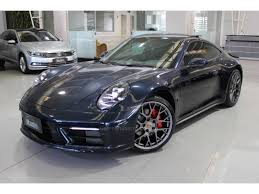

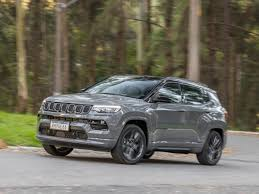

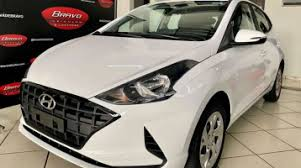

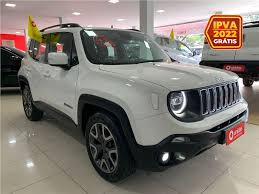

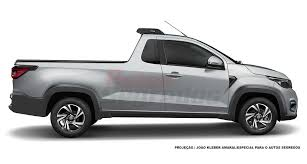

In [10]:
from IPython.display import Image 

# Mostrar algumas imagens
for classe in indice_para_classe.values():
    pasta_classe = os.path.join(pasta_treino, classe)
    arquivo_imagem = os.listdir(pasta_classe)[1]
    img = Image(filename=os.path.join(pasta_classe, arquivo_imagem))
    display(img)

### Carrega a rede pré-treinada _AlexNet_

Conforme detalhado no relatório, a _AlexNet_ é implementada no _PyTorch_ em 3 partes, _(features), (avgpool) e (classifier_):
1. Extração de Características (_feature extraction_);
2. Camada de _pooling_ baseada em valores médios (_AdaptiveAvgPool2d_);
3. Classificador.

In [11]:
alexnet = models.alexnet(pretrained=True)

In [12]:
alexnet.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [13]:
alexnet.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

### Congela os parâmetros da rede

Como se trata de uma rede pré-treinada e queremos utilizar a técnica de _transfer learning_, é necessário congelar seus parâmetros para que as camadas anteriores não sejam retreinadas.

In [14]:
# Congelar os parametros da rede pré-treinada
for param in alexnet.parameters():
    param.requires_grad = False

### Configura a última camada com o número de classes desejada e adiciona mais uma camada de classificação

A _AlexNet_ foi treinada para classificar 1000 categorias (`(6): Linear(in_features=4096, out_features=1000, bias=True)`). O trecho abaixo ajusta essa saída para o número de categorias que desejamos classificar (`alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)`) e adiciona ao final uma camada de classificação _LogSoftmax_ (`alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))`), que possibilitará o uso da função de erro log-verossimilhança negativa (_Negative Loss Likelihood - NNLog_). 

In [15]:
alexnet.classifier[6] = nn.Linear(4096, numero_de_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Verificar se há GPU disponível

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
summary(alexnet, (3, tamanho, tamanho), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

### Define a função de erro e otimizador

No trecho abaixo são definidas a função de erro e otimização. Para o projeto, foram escolhidas as funções de erro log-verossimilhança negativa (_Negative Loss Likelihood - NNLog_) e otimização Adam, conforme sugerigo no artigo do Sunita Nayak.

In [18]:
funcao_erro = nn.NLLLoss() 
otimizador = optim.Adam(alexnet.parameters()) 
otimizador

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    maximize: False
    weight_decay: 0
)

### Cria a função de treinamento da rede

A função abaixo será utilizada para treinar e validar a rede utilizando os conjuntos de dados de treino e validação.

In [19]:
def treinar_e_validar(modelo, metrica_erro, otimizador_sgd, epocas=25):
    '''
    Função para treinamento e validação
    Parâmetros
        :param modelo: modelo para treinar e validar
        :param metrica_erro: critério de erro para minização
        :param otimizador_sgd: otimizador para calcular os gradientes
        :param epocas: número de épocas (default=25)
  
    Retorna
        melhor_modelo: modelo treinado com a melhor acurácia na validação
        historico: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    # inicializando historico, a melhor acuracia de validação e o melhor modelo de acordo com a validação
    historico = []
    melhor_acuracia = 0.0
    melhor_modelo = None

    # Cada época passa por todas as imagens do treino e calcula erros de treino e validação
    # para aprendizado da rede neural
    for epoca in range(epocas):
        inicio_epoca = time.time()
        print("\n\nÉpoca: {}/{}".format(epoca+1, epocas))
        
        # Mudar o modelo para modo treino: vai atualizar os parametros da rede neural
        modelo.train()
        
        # Erro e acurácia de treino nessa época
        erro_treino = 0.0
        acuracia_treino = 0.0
        
        # Erro e acurácia de validação nessa época
        erro_validacao = 0.0
        acuracia_validacao = 0.0
        
        # Itera a cada lote de imagem. As entradas são os tensores do lote (batch)
        # e o label são as classificações de cada imagem do lote:        
        for i, (entradas, labels) in enumerate(data_loader_treino):

            # joga pra GPU ou CPU, dependendo do seu hardware
            entradas = entradas.to(device)
            labels = labels.to(device)
            
            # Limpar os gradientes: zerar os gradientes
            otimizador_sgd.zero_grad()
            
            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            saidas = modelo(entradas)
            
            # Calcular erro das saidas que foram preditas no forward pass
            # comparando com as classificacoes reais (predito vs real)
            erro = metrica_erro(saidas, labels)
            
            # Realizar backpropagation do erro para treinar os coeficientes da rede
            erro.backward()
            
            # Atualizar os parâmetros do otimizador (no nosso caso, Adam Optimizer)
            otimizador_sgd.step()
            
            # Calcular o erro total para esse lote (batch) e soma o erro no treino
            erro_treino += erro.item() * entradas.size(0)
            
            # Cálculo da acurácia
            # Pra calcular a acurácia busca-se as classes preditas para cada imagem no lote                      
            valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
            predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))
            
            # Converter os acertos para float e calcular a acurácia média
            acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em acuracia_treino
            acuracia_treino += acuracia.item() * entradas.size(0)
            
            print("Treino - Lote número {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(i, erro.item(), acuracia.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        with torch.no_grad():

            # Mudando de treino para validação
            modelo.eval()

            # Iteração de validação
            for j, (entradas, labels) in enumerate(data_loader_validacao):
                entradas = entradas.to(device)
                labels = labels.to(device)

                # Forward pass de validação
                saidas = modelo(entradas)

                # Calcular erro de validação
                erro = metrica_erro(saidas, labels)

                # Calcular erro de validação e adicionar à erro_validação
                erro_validacao += erro.item() * entradas.size(0)

                # Calcular a acurácia de validação
                valores_maximos, indices_dos_valores_maximos = torch.max(saidas.data, 1)
                predicoes_corretas = indices_dos_valores_maximos.eq(labels.data.view_as(indices_dos_valores_maximos))

                # Converter os acertos para float e calcular a acurácia média
                acuracia = torch.mean(predicoes_corretas.type(torch.FloatTensor))

                # Calcular a acurácia total de validação do lote todo e adicionar a em acuracia_validacao
                acuracia_validacao += acuracia.item() * entradas.size(0)

                print("Validação - Lote número: {:03d}, Erro: {:.4f}, Acurácia: {:.4f}".format(j, erro.item(), acuracia.item()))
            
        # Calcular a média de erro e acurácia no treino
        erro_medio_treino = erro_treino/num_imagens_treino
        acuracia_media_treino = acuracia_treino/num_imagens_treino

        # Calcular a média de erro e acurácia na validação
        erro_medio_validacao = erro_validacao/num_imagens_validacao
        acuracia_media_validacao = acuracia_validacao/num_imagens_validacao

        # Incluir no histórico os erros e acurácias médias
        historico.append([erro_medio_treino, erro_medio_validacao, acuracia_media_treino, acuracia_media_validacao])
                
        fim_epoca = time.time()
    
        print("Época : {:03d}, Treino: Erro: {:.4f}, Acurácia: {:.4f}%, \n\t\tValidação : Erro : {:.4f}, Acurácia: {:.4f}%, Tempo: {:.4f}s".format(epoca+1, erro_medio_treino, acuracia_media_treino*100, erro_medio_validacao, acuracia_media_validacao*100, fim_epoca-inicio_epoca))
        
        # Testa se a acurácia na validação desse modelo nessa época é a melhor
        # Se for a melhor, salva no melhor modelo e na melhor acurácia
        if acuracia_media_validacao > melhor_acuracia:
            melhor_acuracia = acuracia_media_validacao
            torch.save(modelo, './modelos/melhor_modelo.pt')
            melhor_modelo = modelo
            
    return melhor_modelo, historico

### Define o número de épocas e treina o modelo

O trecho abaixo verifica se há GPU disponível para o treinamento, define o número de épocas em 40 e treina o modelo.

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device}\n')

numero_de_epocas = 40

modelo_treinado, historico = treinar_e_validar(alexnet, funcao_erro, otimizador, numero_de_epocas)

cpu



Época: 1/40
Treino - Lote número 000, Erro: 1.6426, Acurácia: 0.2656
Treino - Lote número 001, Erro: 1.6536, Acurácia: 0.2578
Treino - Lote número 002, Erro: 1.3716, Acurácia: 0.4062
Treino - Lote número 003, Erro: 1.2130, Acurácia: 0.5714
Validação - Lote número: 000, Erro: 1.2012, Acurácia: 0.5273
Época : 001, Treino: Erro: 1.5498, Acurácia: 31.4578%, 
		Validação : Erro : 1.2012, Acurácia: 52.7273%, Tempo: 5.4694s


Época: 2/40
Treino - Lote número 000, Erro: 1.1316, Acurácia: 0.5938
Treino - Lote número 001, Erro: 1.0290, Acurácia: 0.6250
Treino - Lote número 002, Erro: 1.0217, Acurácia: 0.6016
Treino - Lote número 003, Erro: 0.7911, Acurácia: 0.8571
Validação - Lote número: 000, Erro: 1.0077, Acurácia: 0.6182
Época : 002, Treino: Erro: 1.0559, Acurácia: 61.1253%, 
		Validação : Erro : 1.0077, Acurácia: 61.8182%, Tempo: 3.8976s


Época: 3/40
Treino - Lote número 000, Erro: 0.8387, Acurácia: 0.7734
Treino - Lote número 001, Erro: 0.7805, Acurácia: 0.7734
Treino - Lote número 

Validação - Lote número: 000, Erro: 0.6734, Acurácia: 0.7364
Época : 020, Treino: Erro: 0.2137, Acurácia: 93.6061%, 
		Validação : Erro : 0.6734, Acurácia: 73.6364%, Tempo: 4.0721s


Época: 21/40
Treino - Lote número 000, Erro: 0.1863, Acurácia: 0.9688
Treino - Lote número 001, Erro: 0.2039, Acurácia: 0.9297
Treino - Lote número 002, Erro: 0.2301, Acurácia: 0.9453
Treino - Lote número 003, Erro: 0.2990, Acurácia: 0.8571
Validação - Lote número: 000, Erro: 0.6488, Acurácia: 0.7909
Época : 021, Treino: Erro: 0.2084, Acurácia: 94.6292%, 
		Validação : Erro : 0.6488, Acurácia: 79.0909%, Tempo: 3.9355s


Época: 22/40
Treino - Lote número 000, Erro: 0.2165, Acurácia: 0.9297
Treino - Lote número 001, Erro: 0.2200, Acurácia: 0.9297
Treino - Lote número 002, Erro: 0.1800, Acurácia: 0.9531
Treino - Lote número 003, Erro: 0.1654, Acurácia: 0.8571
Validação - Lote número: 000, Erro: 0.6448, Acurácia: 0.7818
Época : 022, Treino: Erro: 0.2048, Acurácia: 93.6061%, 
		Validação : Erro : 0.6448, Acurác



Época: 40/40
Treino - Lote número 000, Erro: 0.1355, Acurácia: 0.9609
Treino - Lote número 001, Erro: 0.0965, Acurácia: 0.9688
Treino - Lote número 002, Erro: 0.1302, Acurácia: 0.9609
Treino - Lote número 003, Erro: 0.1074, Acurácia: 1.0000
Validação - Lote número: 000, Erro: 0.5825, Acurácia: 0.8000
Época : 040, Treino: Erro: 0.1205, Acurácia: 96.4194%, 
		Validação : Erro : 0.5825, Acurácia: 80.0000%, Tempo: 3.8357s


### Gráfico de Erro nos conjuntos de Treino e Validação

Text(0, 0.5, 'Erro')

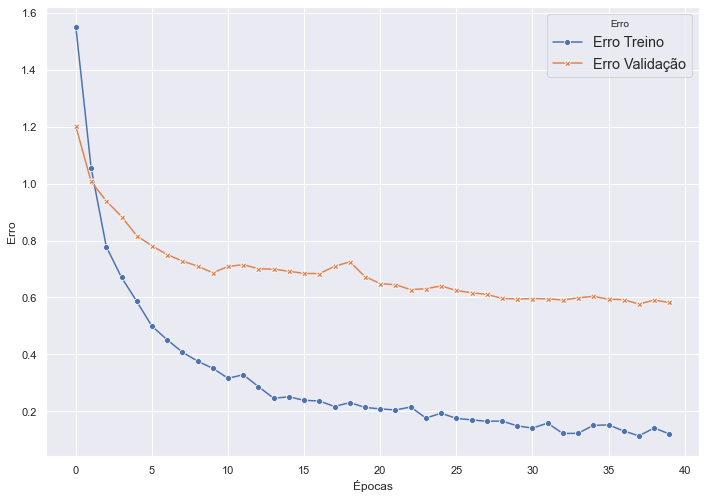

In [21]:
historico = np.array(historico)
ax=sns.lineplot(data=historico[:,0:2],markers=True, dashes=False)
plt.legend(labels=["Erro Treino","Erro Validação"], title = "Erro", 
           fontsize = 'large', title_fontsize = "10")
ax.set_xlabel("Épocas")
ax.set_ylabel("Erro")

### Gráfico de Acurácia nos conjuntos de Treino e Validação

Text(0, 0.5, 'Acurácia')

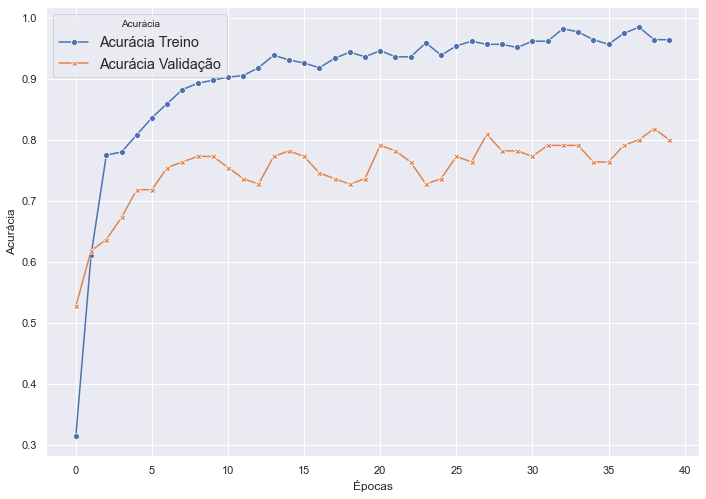

In [22]:
ax = sns.lineplot(data=historico[:,-2:],markers=True, dashes=False)
plt.legend(labels=["Acurácia Treino","Acurácia Validação"], title = "Acurácia", 
           fontsize = 'large', title_fontsize = "10")
ax.set_xlabel("Épocas")
ax.set_ylabel("Acurácia")

### Verifica qual o maior valor de acurácia no conjunto de Validação

Foi obtido um valor de 0.8181, ou seja, o melhor modelo teve acurácia de 81,8% no conjunto de validação.

In [23]:
#Ordena as maioresvalidações
validacoes = historico[:,3]
maior_val = np.sort(validacoes)[::-1]
print(maior_val[0])

0.8181818127632141


### Define função para efetuar predições

O trecho abaixo define a função responsável por efetuar as predições de imagens utilizando o melhor modelo obtido no treinamento da rede.

In [24]:
def predicao(modelo, arquivo_imagem_teste):
    '''
    Função para realizar a predição do modelo do automóvel
    Parâmetros
        :param modelo: modelo para testar
        :param arquivo_imagem_teste: caminho para imagem de teste
    '''
    
    transformacao = transformacoes_de_imagens['teste']

    imagem_teste = PIL.Image.open(arquivo_imagem_teste)
    #plt.imshow(imagem_teste)
    
    tensor_imagem_teste = transformacao(imagem_teste)
    #print(tensor_imagem_teste.size())

    # Testa se voce é rico, ops, se tem uma placa NVIDIA :)
    if torch.cuda.is_available():
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, tamanho, tamanho).cuda()
    else:
        tensor_imagem_teste = tensor_imagem_teste.view(1, 3, tamanho, tamanho)
    
    dict_predicoes = dict()
    
    # Não precisa atualizar os coeficientes do modelo
    with torch.no_grad():
        modelo.eval()
        # Modelo retorna as probabilidades em log (log softmax)
        saida = modelo(tensor_imagem_teste)
        
        # torch.exp para voltar a probabilidade de log para a probabilidade linear
        ps = torch.exp(saida)
        
        # topk retorna o os k maiores valores do tensor
        # o tensor de probabilidades vai trazer na 1a posição a classe com maior
        # probabilidade de predição
        topk, topclass = ps.topk(numero_de_classes, dim=1)        
        for i in range(numero_de_classes):
            dict_predicoes[indice_para_classe[topclass.cpu().numpy()[0][i]]] = topk.cpu().numpy()[0][i]    
    
    return dict_predicoes

### Testa a classe de predições

O código abaixo teste imagens individuais e faz a inferência da categoria

In [25]:
classe = '911'
pasta = f'./dados/teste/{classe}/'
imagem = os.path.join(pasta, os.listdir(pasta)[4])
#print(indice_para_classe)
predicao(modelo_treinado, imagem)
#print(list(pred.keys())[0])
#print(pred)


{'911': 0.9439019,
 'HB20': 0.035868283,
 'COMPASS': 0.015226686,
 'STRADA': 0.0036914865,
 'RENEGADE': 0.00131167}

### Inferências no conjunto de dados de Teste

O código abaixo pega todas as imagens do conjunto de teste - nunca vistas pelo modelo na fase de treino e validação - e verifica a acurácia média desse conjunto. Foi obtido um valor de 0.8679, ou seja, a acurácia média no conjunto de teste foi de 86,8%.

In [26]:
def acuracia_teste(modelo, pasta_teste):
    classes = os.listdir(pasta_teste)
    print(classes)
    
    predicoes_corretas = 0
    predicoes_erradas = 0
    
    for cl in classes:
        cl1_files = os.listdir(os.path.join(pasta_teste, cl))
        
        for image in cl1_files:
            full_path_image = os.path.join(pasta_teste, cl, image)
            p = predicao(modelo, full_path_image)
            predicted_class = max(p, key=lambda key: p[key])
            
            
            if predicted_class == cl:
                predicoes_corretas += 1
            else:
                predicoes_erradas += 1                
    
    return predicoes_corretas / (predicoes_corretas + predicoes_erradas)

In [27]:
melhor_modelo = torch.load('./modelos/melhor_modelo.pt')
acuracia_base_teste = acuracia_teste(melhor_modelo, pasta_teste)
acuracia_base_teste

['911', 'COMPASS', 'HB20', 'RENEGADE', 'STRADA']


0.8679245283018868